In [38]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import glob
import librosa
import librosa.display
import datasets.dcase_few_shot_bioacoustic as util
import datasets.data_gen as dg

import matplotlib.pyplot as plt

import IPython.display as ipd

# README
This is a notebook for sound event prediction audiation. Audiation is to hearing what visualization is to vision. This tool is useful if you want to browse through the sound events in a prediciton / annotation .csv file of the type:

    filname, start-time, end-time, class
    <filename>.wav, <start-second>, <end-second>, <event-class>

In [2]:
ls '/home/willbo/data/dcase/val'

a1.csv                    BUK4_20161011_000804.csv   BUK5_20180921_015906a.csv
a1.wav                    BUK4_20161011_000804.wav   BUK5_20180921_015906a.wav
BUK1_20181011_001004.csv  BUK4_20171022_004304a.csv  n1.csv
BUK1_20181011_001004.wav  BUK4_20171022_004304a.wav  n1.wav
BUK1_20181013_023504.csv  BUK5_20161101_002104a.csv
BUK1_20181013_023504.wav  BUK5_20161101_002104a.wav


In [55]:
root_path = '/home/willbo/data/dcase/val/'
filename = 'BUK4_20161011_000804'

annotation_file_path = os.path.join(root_path, filename) + '.csv'
audio_file_path = os.path.join(root_path, filename) + '.wav'
print(annotation_file_path)
print(audio_file_path)

/home/willbo/data/dcase/val/BUK4_20161011_000804.csv
/home/willbo/data/dcase/val/BUK4_20161011_000804.wav


In [3]:
def select_events_with_value(data_frame, value='POS'):
    indices = data_frame.index[data_frame['class'] == value].tolist()
    return indices

def build_matrix_from_selected_rows(data_frame, selected_indices):
    matrix_data = np.ones((2, len(selected_indices)))* -1
    for n, idx in enumerate(selected_indices):
        matrix_data[0, n] = data_frame.loc[idx]['start-time']
        matrix_data[1, n] = data_frame.loc[idx]['end-time']
    return matrix_data

def load_prediction_dataframe(prediction_file_path, annotation_file_path, filename):
    prediction_dataframe = pd.read_csv(prediction_file_path)
    prediction_dataframe['class'] = 'POS'
    prediction_dataframe.columns = ['filename', 'start-time', 'end-time', 'class']
    predicted_events_by_audiofile = dict(tuple(prediction_dataframe.groupby('filename')))
    prediction_dataframe = predicted_events_by_audiofile[filename + '.wav']
    
    annotation_dataframe = load_annotation_dataframe(annotation_file_path)
    
    ref_pos_indices = select_events_with_value(annotation_dataframe, value='POS')
    pred_pos_indices = select_events_with_value(prediction_dataframe, value='POS')

    ref_1st_round = build_matrix_from_selected_rows(annotation_dataframe, ref_pos_indices)
    pred_1st_round = build_matrix_from_selected_rows(prediction_dataframe, pred_pos_indices)

    m_pos = util.match_events(ref_1st_round, pred_1st_round, min_iou=0.3)
    tp_indices = np.array([x[1] for x in m_pos])
    for i, (index, row) in enumerate(prediction_dataframe.iterrows()):
        if i in tp_indices:
            prediction_dataframe.at[index, 'class'] = 'TP'
        else:
            prediction_dataframe.at[index, 'class'] = 'FP'
    
    return prediction_dataframe

def load_annotation_dataframe(file_path):
    annotation_dataframe = pd.read_csv(file_path)
    annotation_dataframe.columns = ['filename', 'start-time', 'end-time', 'class']
    
    return annotation_dataframe

In [56]:
prediction_file_path = '/home/willbo/repos/soundscape-analysis/few_shot_learning/outputs/rbigg_specaugemnt_lazytest_l2_650neg_lr5_notile02/PP_BEST_VAL_out.csv'
prediction_df = load_prediction_dataframe(prediction_file_path, annotation_file_path, filename)
prediction_df[:5]

,filename,start-time,end-time,class
74,BUK4_20161011_000804.wav,356.496000,356.588917,FP
75,BUK4_20161011_000804.wav,371.867583,372.006917,FP
76,BUK4_20161011_000804.wav,372.053333,372.192667,FP
77,BUK4_20161011_000804.wav,373.260833,373.400167,FP
78,BUK4_20161011_000804.wav,373.678750,373.725250,FP


In [57]:
annotation_df = load_annotation_dataframe(annotation_file_path)
annotation_df[:5]

,filename,start-time,end-time,class
0,BUK4_20161011_000804.wav,91.446324,91.465685,POS
1,BUK4_20161011_000804.wav,105.023503,105.063170,POS
2,BUK4_20161011_000804.wav,169.152942,169.170442,POS
3,BUK4_20161011_000804.wav,204.470003,204.496626,POS
4,BUK4_20161011_000804.wav,264.650134,264.664366,POS


In [6]:
def play_first_audio_events(audio_file_path, annotation_df, event_class, n=5, expand=0):
    audio, sample_rate = librosa.load(audio_file_path, None)
    print(sample_rate)
    event_df = annotation_df[annotation_df['class'] == event_class][:n]
    audio_objects = []
    for index, row in event_df.iterrows():
        start_time = float(row['start-time'])
        end_time   = float(row['end-time'])
        
        start_idx = int((start_time-expand)*sample_rate)
        end_idx = int((end_time+expand)*sample_rate)
        
        if start_idx < 0:
            start_idx = 0
        if end_idx > len(audio):
            end_idx = len(audio)
        
        audio_segment = audio[start_idx:end_idx]
        audio_object = ipd.Audio(audio_segment, rate=sample_rate)
        ipd.display(audio_object)
        
def get_first_audio_events(audio_file_path, annotation_df, event_class, n=5, expand=0):
    audio, sample_rate = librosa.load(audio_file_path, None)
    print(sample_rate)
    event_df = annotation_df[annotation_df['class'] == event_class][:n]
    audio_segments = []
    for index, row in event_df.iterrows():
        start_time = float(row['start-time'])
        end_time   = float(row['end-time'])
        
        start_idx = int((start_time-expand)*sample_rate)
        end_idx = int((end_time+expand)*sample_rate)
        
        if start_idx < 0:
            start_idx = 0
        if end_idx > len(audio):
            end_idx = len(audio)
        
        audio_segment = audio[start_idx:end_idx]
        audio_segments.append(audio_segment)
    return audio_segments
        
def play_random_audio_events(audio_file_path, annotation_df, event_class, n=5, expand=0):
    audio, sample_rate = librosa.load(audio_file_path, None)
    event_df = annotation_df[annotation_df['class'] == event_class][:n]
    audio_objects = []
    audio_segments = []
    for index, row in event_df.iterrows():
        start_time = float(row['start-time'])
        end_time   = float(row['end-time'])
        
        start_idx = int((start_time-expand)*sample_rate)
        end_idx = int((end_time+expand)*sample_rate)
        
        if start_idx < 0:
            start_idx = 0
        if end_idx > len(audio):
            end_idx = len(audio)
        
        audio_segment = audio[start_idx:end_idx]
        audio_segments.append(audio_segment)

    if n > len(audio_segments):
        n = len(audio_segments)
    
    random_choice_indices = np.random.choice(np.arange(n), n, replace=False)

    for idx in random_choice_indices:
        audio_object = ipd.Audio(audio_segments[idx], rate=sample_rate)
        ipd.display(audio_object)
    
    return [audio_segments[idx] for idx in random_choice_indices]

In [42]:
play_first_audio_events(audio_file_path, annotation_df, event_class='POS', n=5, expand=0.025)

6000


44100


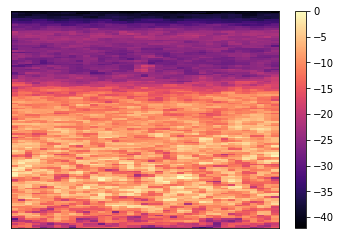

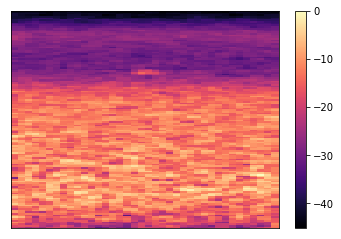

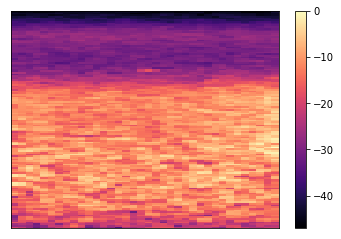

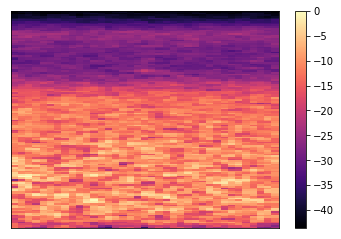

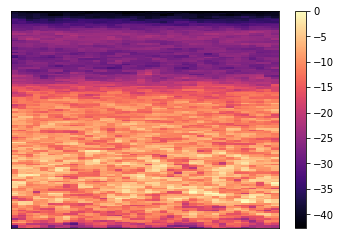

In [58]:
audio_segments = get_first_audio_events(audio_file_path, annotation_df, event_class='POS', n=5, expand=0.2)
for audio_segment in audio_segments:
    D = librosa.stft(audio_segment)  # STFT of y
    D = librosa.feature.melspectrogram(audio_segment, sr=44100)
    S_db = librosa.power_to_db(np.abs(D), ref=np.max)
    plt.figure()
    librosa.display.specshow(S_db)
    plt.colorbar()

In [44]:
class ConfigDummy():
    
    def __init__(self):
        self.experiment = Experiment()
        
class Experiment():
    
    def __init__(self):
        self.datagen = Datagen()
        self.path = Path()

class Path():
    
    def __init__(self):
        self.train_features = '/home/willbo/data/dcase/hfiles/train'
        
class Datagen():
    
    def __init__(self):
        self.ltoi = True
        self.balance = True
        self.normalize = True
        self.raw = False

gen = dg.Datagen(ConfigDummy())

In [64]:
import scipy

44100
(128, 73)
(128, 76)
(128, 72)
(128, 74)
(128, 72)


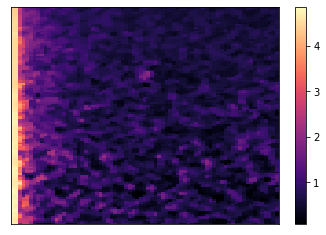

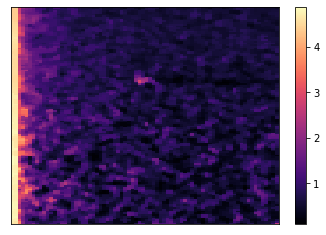

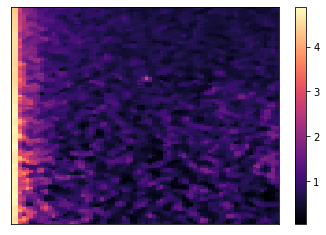

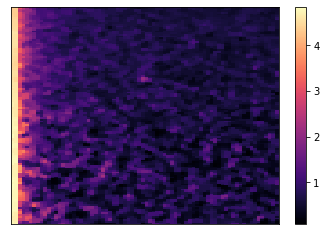

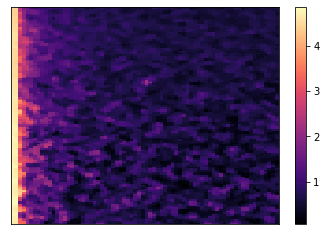

In [75]:
audio_segments = get_first_audio_events(audio_file_path, annotation_df, event_class='POS', n=5, expand=0.2)
for audio_segment in audio_segments:
    audio_segment = audio_segment * (2**32)
    #D = librosa.stft(audio_segment)  # STFT of y
    D = librosa.feature.melspectrogram(audio_segment, sr=22050, n_fft=1024, hop_length=256, n_mels=128, fmax=11025)
    D_pcen = librosa.core.pcen(D, 22050)
    D_pcen_n = gen.feature_scale(D_pcen)
    
    
    D_filt = scipy.ndimage.median_filter(D_pcen, (3,2))
    
    #S_db = librosa.power_to_db(np.abs(D), ref=np.max)
    #print(S_db.shape)
    print(D.shape)
    plt.figure()
    #librosa.display.specshow(D)
    #librosa.display.specshow(D_pcen)
    librosa.display.specshow(D_filt)
    plt.colorbar()

In [39]:
play_random_audio_events(audio_file_path, prediction_df, event_class='TP', n=20, expand=0)

[array([0.00039673, 0.00048828, 0.0007019 , ..., 0.00195312, 0.00189209,
        0.00024414], dtype=float32),
 array([-0.00210571, -0.00061035,  0.00045776, ...,  0.00134277,
         0.00506592,  0.00473022], dtype=float32),
 array([ 0.0017395 ,  0.00137329, -0.00021362, ...,  0.00164795,
         0.0020752 ,  0.00146484], dtype=float32),
 array([ 0.00115967,  0.00158691,  0.00067139, ..., -0.00015259,
         0.        , -0.00076294], dtype=float32),
 array([ 8.2397461e-04,  1.9836426e-03, -9.1552734e-05, ...,
         3.1127930e-03,  4.0588379e-03,  4.9438477e-03], dtype=float32),
 array([0.00152588, 0.00411987, 0.00125122, ..., 0.00146484, 0.00128174,
        0.00109863], dtype=float32),
 array([-0.00048828,  0.00219727,  0.00036621, ..., -0.00601196,
        -0.00857544, -0.00671387], dtype=float32),
 array([0.00109863, 0.00100708, 0.00039673, ..., 0.00045776, 0.00115967,
        0.00064087], dtype=float32),
 array([ 0.00201416,  0.00140381,  0.00125122, ..., -0.0246582 ,
       

In [41]:
segments = play_random_audio_events(audio_file_path, prediction_df, event_class='FP', n=50, expand=0.0)

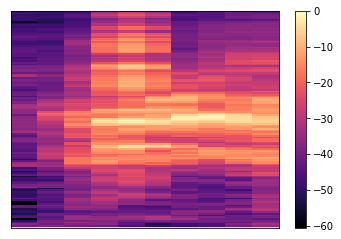

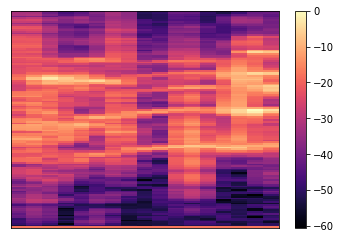

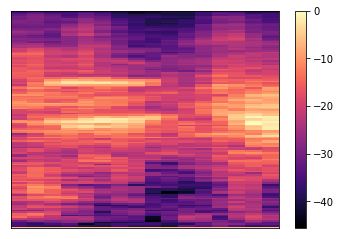

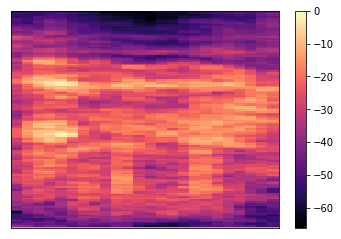

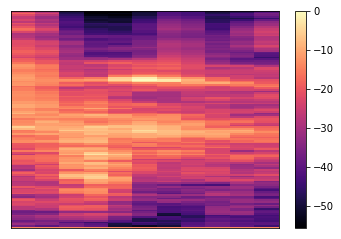

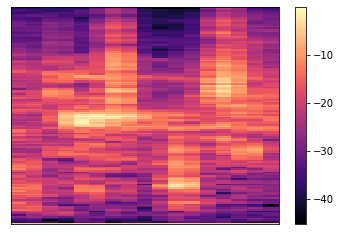

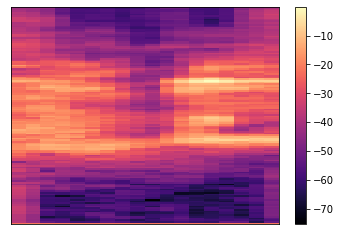

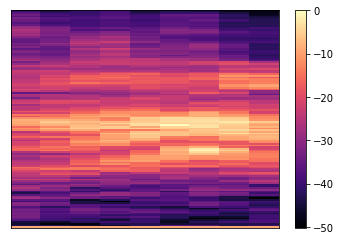

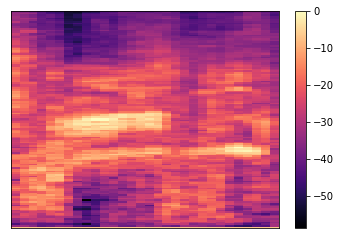

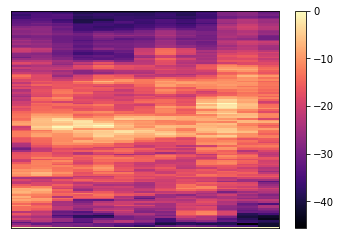

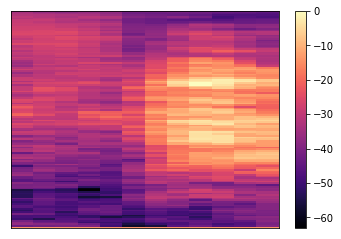

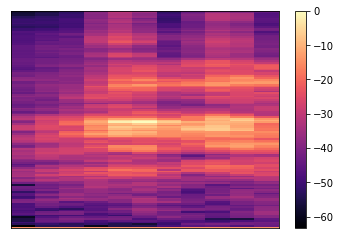

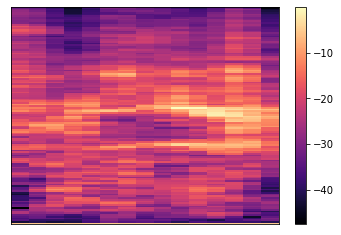

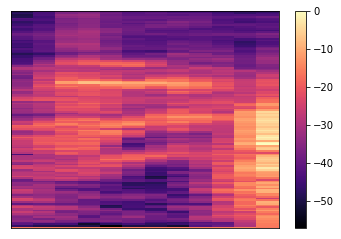

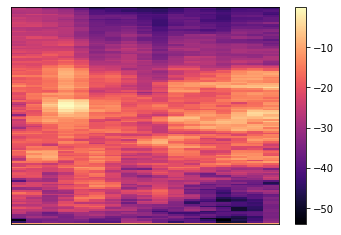

In [25]:
for audio_segment in segments:
    D = librosa.stft(audio_segment)  # STFT of y
    D = librosa.feature.melspectrogram(audio_segment, sr=44100)
    S_db = librosa.power_to_db(np.abs(D), ref=np.max)
    plt.figure()
    librosa.display.specshow(S_db)
    plt.colorbar()

In [39]:
segments = play_random_audio_events(audio_file_path, prediction_df, event_class='FN', n=5, expand=0.4)

In [ ]:
for audio_segment in segments:
    D = librosa.stft(audio_segment)  # STFT of y
    D = librosa.feature.melspectrogram(audio_segment, sr=44100)
    S_db = librosa.power_to_db(np.abs(D), ref=np.max)
    plt.figure()
    librosa.display.specshow(S_db)
    plt.colorbar()

In [ ]:
print(audio_file_path)
audio, sample_rate = librosa.load(audio_file_path, None)
ipd.Audio(audio[:sample_rate*100], rate=sample_rate)